## 13.1.2 はじめてのTheano

Theanoの手続き3ステップ

- 定義
- コンパイル
- 実行

テンソルはスカラー、ベクトル、行列などを一般化したもの  

- スカラーは階数0
-　ベクトルは階数1
- 行列は階数2
- 3次の積み上げ行列は階数3のテンソル

重み$w_1$、バイアス$w_0$の一次元のデータセットでサンプル点$x$の総入力$z$を計算してみる  

$$ z = x_1 \times w_1 + w_0 $$

In [3]:
import theano
from theano import tensor as T

# 初期化
x1 = T.scalar()
w1 = T.scalar()
w0 = T.scalar()
z1 = w1 * x1 + w0

# コンパイル
net_input = theano.function(inputs=[w1, x1, w0], outputs=z1)

# 実行
print("Net print: %.2f" % net_input(2.0, 1.0, 0.5))

Net print: 2.50


## 13.1.3 Theanoを設定
最近のOSは64bitのメモリアドレスを使う  
ただし数式の評価をGPUで高速化したい場合は、従来の32bitが多い  

デフォルトではNumPyもTheanoもfloat64をしようする
``theano.config.floatX``でTheanoの設定にアクセスできる  
また現在のPythonセッションで切り替えたい場合は``theano.config.floatX = 'float32'``  

CPUかGPUの確認は``print(theano.config.device``

.theanorcの書き方は

```
[global]
floatX=32
device=gpu
```

## 13.1.4 配列構造の操作

In [5]:
import numpy as np
# 初期化
# Theanoを64bitで実行している場合は、
# fmatrixの代わりにdmatrixを使用することがある
x = T.fmatrix(name='x')
x_sum = T.sum(x, axis=0)

# コンパイル
calc_sum = theano.function(inputs=[x], outputs=x_sum)

# 実行(Pythonリスト)
ary = [[1, 2, 3], [1, 2, 3]]
print("Column sum", calc_sum(ary))

# 実行(NumPy配列)
ary = np.array([[1, 2, 3], [1, 2, 3]], dtype=theano.config.floatX)
print("Column sum", calc_sum(ary))

('Column sum', array([ 2.,  4.,  6.], dtype=float32))
('Column sum', array([ 2.,  4.,  6.], dtype=float32))


In [6]:
# 初期化
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)
update = [[w, w + 1.0]]

# コンパイル
net_input = theano.function(inputs=[x], updates=update, outputs=z)

# 実行
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
for i in range(5):
    print('z%d: ' % i, net_input(data))

('z0: ', array([[ 0.]], dtype=float32))
('z1: ', array([[ 6.]], dtype=float32))
('z2: ', array([[ 12.]], dtype=float32))
('z3: ', array([[ 18.]], dtype=float32))
('z4: ', array([[ 24.]], dtype=float32))


``theano.function``で``inputs``引数を使用する場合、データはCPUからGPUになんども転送される  
givens変数を使用すれば、コンパイル前にグラフに値を挿入することができる  

In [9]:
# 初期化
data = np.array([[1, 2, 3]], dtype=theano.config.floatX)
x = T.fmatrix('x')
w = theano.shared(np.asarray([[0.0, 0.0, 0.0]], dtype=theano.config.floatX))
z = x.dot(w.T)

update = [[w, w + 1.0]]

# コンパイル
net_input = theano.function(inputs=[], updates=update, givens={x: data}, outputs=z)

# 実行
for i in range(5):
    print('z%d: ' % i, net_input())

('z0: ', array([[ 0.]], dtype=float32))
('z1: ', array([[ 6.]], dtype=float32))
('z2: ', array([[ 12.]], dtype=float32))
('z3: ', array([[ 18.]], dtype=float32))
('z4: ', array([[ 24.]], dtype=float32))


## 13.1. 5 線形回帰の例

In [10]:
X_train = np.asarray([[0.0], [1.0],
                                      [2.0], [3.0],
                                      [4.0], [5.0],
                                      [6.0], [7.0],
                                      [8.0], [9.0]],
                                     dtype=theano.config.floatX)
y_train = np.asarray([1.0, 1.3,
                                      3.1, 2.0,
                                      5.0, 6.3,
                                      6.6, 7.4,
                                      8.0, 9.0],
                                     dtype=theano.config.floatX)

In [11]:
import theano
from theano import tensor as T
import numpy as np

def train_linreg(X_train, y_train, eta, epochs):
    
    costs=[]
    # 配列の初期化
    eta0 = T.fscalar('eta0') # float32型のスカラーのインスタンス
    y = T.fvector(name='y') # float32型のベクトルのインスタンス
    X = T.fmatrix(name='X') # float32型の行列のインスタンス
    # 重みwを関数内で参照可能な共有変数として作成
    w = theano.shared(np.zeros(shape=(X_train.shape[1] + 1), dtype=theano.config.floatX), name='w')
    
    # コストの計算
    net_input = T.dot(X, w[1:]) + w[0] # 重みを用いて総入力を計算
    errors = y - net_input # yと総入力の誤差
    cost = T.sum(T.pow(errors, 2)) # 誤差の２乗和
    
    # 重みの更新
    gradient = T.grad(cost, wrt=w) # コストの勾配
    update = [(w, w - eta0 * gradient)] # コストの勾配に学習率をかけて重みwを更新
    
    # モデルのコンパイル
    train = theano.function(inputs=[eta0], outputs=cost, updates=update, givens={X: X_train, y: y_train})
    
    for _ in range(epochs):
        costs.append(train(eta))
        
    return costs, w

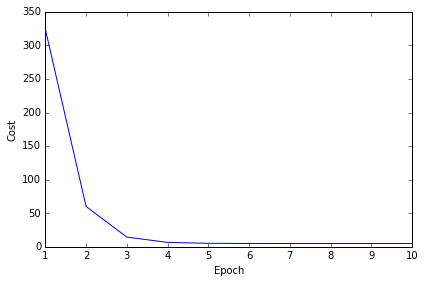

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
costs, w = train_linreg(X_train, y_train, eta=0.001, epochs=10)
plt.plot(range(1, len(costs) + 1), costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.tight_layout()
plt.show()

In [15]:
def predict_linreg(X, w):
    Xt = T.matrix(name='X')
    net_input = T.dot(Xt, w[1:]) + w[0]
    predict = theano.function(inputs=[Xt], givens={w: w}, outputs=net_input)
    
    return predict(X)

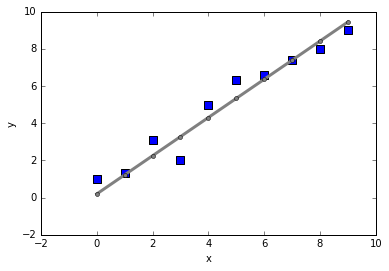

In [16]:
plt.scatter(X_train, y_train, marker='s', s=50)
plt.plot(range(X_train.shape[0]), predict_linreg(X_train, w),
              color='gray', marker='o', markersize=4, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# 13.2 フィードフォワードNNでの活性化関数の選択
シグモイド関数は「ロジスティック関数」または「負の対数尤度関数」  
入力の負の度合いが高い場合は0に近づく  
0に近い出力を返す場合、NNの学習に非常に時間がかかってしまい、極小値に陥る可能性が高くなる  
隠れ層の活性化関数としてtanh関数が用いられるのはそのため。  

## 13.2.1 ロジスティック関数まとめ
ロジスティック関数を利用すれば、二値分類タスクにおいてサンプルxが陽性クラス(クラス1)に分類  

$$\phi{(z)} = \frac{1}{1 + e^{-z}}$$



In [19]:
X = np.array([[1, 1.4, 1.5]])
w = np.array([0.0, 0.2, 0.4])

def net_input(X, w):
    z = X.dot(w)
    return z

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print("P(y=1|x) = %.3f" % logistic_activation(X, w)[0])

P(y=1|x) = 0.707


この値から、サンプルxが陽性クラスに属する確率は70.7%であると解釈できる。  

one-hotエンコーディング手法を用いた、複数のロジスティック活性化ユニットからなる出力層は、  
解釈可能な確率を出力しない。

In [34]:
# W : array, shape = [n_output_units, n_hidden_units + 1]
# 隠れ層 -> 出力層の重み行列
# 最初の列(A[:][0] = 1)がバイアスユニットであることに注意
W = np.array([[1.1, 1.2, 1.3, 0.5],
                          [0.1, 0.2, 0.4, 0.1],
                          [0.2, 0.5, 2.1, 1.9]])

# A : array, shape = [n_hiden+1, n_samples]
# 隠れ層の活性化
# 最初の要素(A[0][0] = 1)がバイアスユニットであることに注意
A = np.array([[1.0],
                         [0.1],
                         [0.3],
                         [0.7]])

# Z : array, shape = [n_output_units, n_samples]
# 出力層の総入力
Z = W.dot(A)
y_probas = logistic(Z)

# Python3系では``print('Probabilities:\n', y_probas)``でいける。
# Python2系はprintの文字列の次に``,``を入れると改行無視になる
print('Probabilities:')
print(y_probas)

Probabilities:
[[ 0.87653295]
 [ 0.57688526]
 [ 0.90114393]]


この出力に示されているように、1つ目のクラスに分類される確率は約88%,  
2つ目のクラスに分類される確率は約58%,  
3つ目のクラスに分類される確率は90%である  

パーセンテージは合わせて100になるものとして表現されておらず、  
このモデルがクラスラベルの予測にのみ使用され、クラスの所属関係の確率には使用されていないとすれば、  
実際にはそれほど大きな問題ではない

In [32]:
y_class = np.argmax(Z, axis=0)
print('predict class label: %d' % y_class[0])

predict class label: 2


クラスへの所属確率を返すという目的には「ソフトマックス関数」で一般化する  

## 13.2.2 ソフトマックス関数を使って多クラス分類の確率を推定
M個の関数の和である正規化項を分母に使用して、各クラスへの所属確率の和が1になるようにしている。  

$$ P(y=i|z) = \phi(z) = \frac{e_i^z}{\sum^M_{m=1}e^z_m} $$

In [36]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

def softmax_activation(X, w):
    z = net_input(X, w)
    return softmax(z)

y_probas = softmax(Z)
print('Probabilities:')
print(y_probas)
y_probas.sum()

Probabilities:
[[ 0.40386493]
 [ 0.07756222]
 [ 0.51857284]]


1.0

ソフトマックス関数については、多クラス分類問題においてクラスの所属関係を効果的に予測するのに役立つ  
**正規化されたロジスティック関数**として考えるのもよいかもしれない  

## 13.2.3 双曲線正接関数を使って出力範囲を拡大する
ロジスティック関数の尺度を取り直したバージョン  
$$ \phi_{tanh}(z) = 2 \times \phi_{logistic}(2 \times z) -1 = \frac{e^z - e^{-z}}{e^z + e^{-z}} $$

双曲線正接関数の利点は、出力範囲が狭く、開区間(-1, 1)におよぶことである。  
このためバックプロパゲーションの収束を改善することが可能である。(詳しいことはPRML)  
対照的にロジスティック関数は開区間(0, 1)の出力信号を返す。  

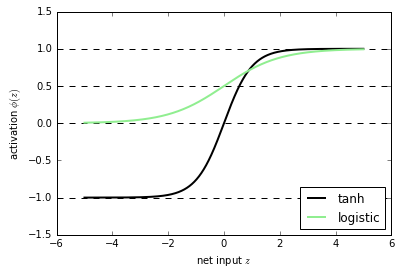

In [38]:
def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)

log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(0.5, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.plot(z, tanh_act, linewidth=2, color='black', label='tanh')
plt.plot(z, log_act, linewidth=2, color='lightgreen', label='logistic')
plt.legend(loc='lower right')
plt.show()

# Kerasを使ったニューラルネットワークの効率的なトレーニング
``pip install keras``